In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Flatten, Dense, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
class Exponential(Layer):
  def __init__(self, output_dim, alpha=1., beta=1., **kwargs):
    self.output_dim = output_dim
    self.alpha = alpha
    self.beta = beta
    super(Exponential, self).__init__(**kwargs)

  def build(self, input_shape):
    self.w_plus = self.add_weight(name='weights_plus', shape=(input_shape[1],self.output_dim), initializer=tf.random_uniform_initializer(minval=0., maxval=.1), trainable=True)
    self.w_negative = self.add_weight(name='weights_negative', shape=(input_shape[1],self.output_dim), initializer=tf.random_uniform_initializer(minval=0., maxval=.1), trainable=True)
    self.b_plus = self.add_weight(shape=(self.output_dim,),initializer='zeros', trainable=True)
    self.b_negative = self.add_weight(shape=(self.output_dim,),initializer='zeros', trainable=True)

  def call(self, inputs):
    w_plus_extended = tf.keras.activations.relu(self.w_plus)
    w_negative_extended = tf.keras.activations.relu(self.w_negative)
    b_plus_extended = tf.keras.activations.relu(self.b_plus)
    b_negative_extended = tf.keras.activations.relu(self.b_negative)

    inputs_extended = tf.expand_dims(inputs, axis=-1)
    inputs_extended = tf.tile(inputs_extended, [1,1,self.output_dim])
    w_plus_extended = tf.expand_dims(w_plus_extended, axis=0)
    w_negative_extended = tf.expand_dims(w_negative_extended, axis=0)
    b_plus_extended = tf.expand_dims(b_plus_extended, axis=0)
    b_negative_extended = tf.expand_dims(b_negative_extended, axis=0)

    plus = tf.reduce_sum(tf.math.exp(self.alpha*(inputs_extended - w_plus_extended)), axis=1) + tf.math.exp(self.alpha*(1.-b_plus_extended))
    negative = tf.reduce_sum(tf.math.exp(self.alpha*(inputs_extended - w_negative_extended)), axis=1) + tf.math.exp(self.alpha*(1.-b_negative_extended))
    return self.beta*tf.math.log(plus/negative)

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

In [4]:
tf.random.set_seed(2024)
inputs = Input(shape=(28,28))
x = Flatten()(inputs)
x = Exponential(300, alpha=4.35, beta=4.)(x)
x = Dropout(0.2)(x)
x = Exponential(10, alpha=4.35, beta=4.)(x)
output = Activation('softmax')(x)
model = Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=100, batch_size=125, validation_data =(x_test, y_test),
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)])

Epoch 1/100
480/480 [==============================] - 19s 27ms/step - loss: 0.5369 - accuracy: 0.8629 - val_loss: 0.2463 - val_accuracy: 0.9369
Epoch 2/100
480/480 [==============================] - 11s 23ms/step - loss: 0.2156 - accuracy: 0.9366 - val_loss: 0.1941 - val_accuracy: 0.9486
Epoch 3/100
480/480 [==============================] - 10s 22ms/step - loss: 0.1786 - accuracy: 0.9458 - val_loss: 0.1711 - val_accuracy: 0.9523
Epoch 4/100
480/480 [==============================] - 11s 23ms/step - loss: 0.1574 - accuracy: 0.9523 - val_loss: 0.1560 - val_accuracy: 0.9563
Epoch 5/100
480/480 [==============================] - 11s 22ms/step - loss: 0.1418 - accuracy: 0.9565 - val_loss: 0.1488 - val_accuracy: 0.9582
Epoch 6/100
480/480 [==============================] - 11s 22ms/step - loss: 0.1319 - accuracy: 0.9599 - val_loss: 0.1393 - val_accuracy: 0.9608
Epoch 7/100
480/480 [==============================] - 11s 22ms/step - loss: 0.1224 - accuracy: 0.9621 - val_loss: 0.1360 - val_ac

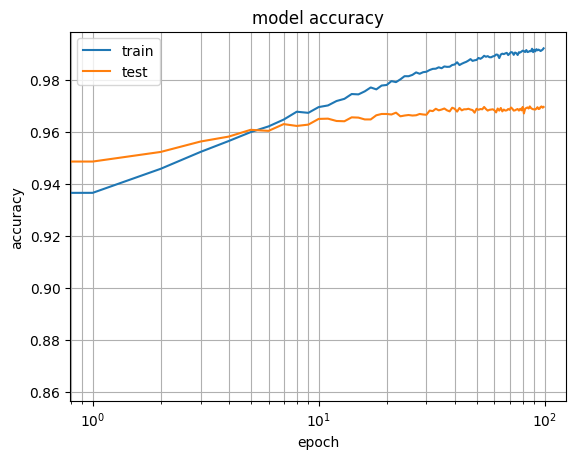

In [5]:
plt.grid(True, which="both")
plt.semilogx(history.history['accuracy'])
plt.semilogx(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [6]:
tf.random.set_seed(2024)
inputs = Input(shape=(28,28))
x = Flatten()(inputs)
x = Dense(600)(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
x = Dense(10)(x)
output = Activation('softmax')(x)
model = Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=100, batch_size=125, validation_data =(x_test, y_test),
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)])

Epoch 1/100
480/480 [==============================] - 3s 4ms/step - loss: 0.2735 - accuracy: 0.9215 - val_loss: 0.1418 - val_accuracy: 0.9588
Epoch 2/100
480/480 [==============================] - 1s 3ms/step - loss: 0.1156 - accuracy: 0.9664 - val_loss: 0.0894 - val_accuracy: 0.9736
Epoch 3/100
480/480 [==============================] - 1s 3ms/step - loss: 0.0790 - accuracy: 0.9767 - val_loss: 0.0755 - val_accuracy: 0.9764
Epoch 4/100
480/480 [==============================] - 1s 3ms/step - loss: 0.0586 - accuracy: 0.9822 - val_loss: 0.0720 - val_accuracy: 0.9780
Epoch 5/100
480/480 [==============================] - 1s 3ms/step - loss: 0.0461 - accuracy: 0.9861 - val_loss: 0.0642 - val_accuracy: 0.9807
Epoch 6/100
480/480 [==============================] - 1s 3ms/step - loss: 0.0381 - accuracy: 0.9877 - val_loss: 0.0619 - val_accuracy: 0.9811
Epoch 7/100
480/480 [==============================] - 1s 3ms/step - loss: 0.0312 - accuracy: 0.9901 - val_loss: 0.0606 - val_accuracy: 0.9814

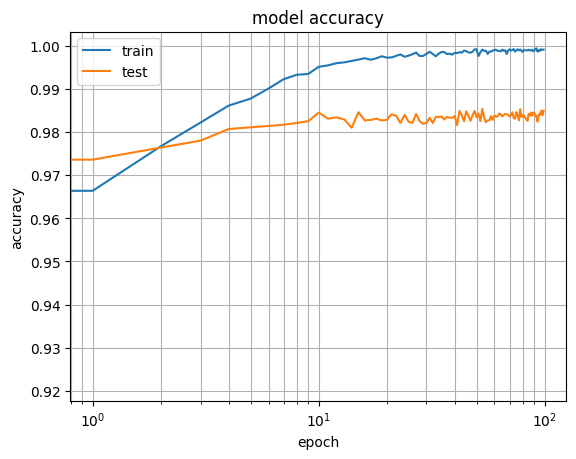

In [7]:
plt.grid(True, which="both")
plt.semilogx(history.history['accuracy'])
plt.semilogx(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()